### **1. Import necessary libraries and modules**

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

from custom_loss_functions import SCCE, SCCEInverse, SCCEMinMaxBin, SCCEMaxBin, SCCEDifference
from custom_layers import DefaultDense, RowWiseQuantized, RowWiseQuantizedSTE, ColumnWiseQuantized, ColumnWiseQuantizedSTE
from custom_callbacks import ScaleTrackingCallback, LossTrackingCallback, AccuracyTrackingCallBack
from utils import print_model_structure, count_unique_values

### **2. Import MNIST data:**

In [10]:
# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

### **3. Define model layers**

The custom `RowWiseQuantizedSTE` can be replaced with other custom layer classes. Refer to `custom_layers.py`.

In [11]:
tf.compat.v1.enable_eager_execution()

input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = RowWiseQuantized(128)(flatten_layer)
quantized_dense_layer_2 = tf.keras.activations.relu(quantized_dense_layer)
output_layer = RowWiseQuantized(10)(quantized_dense_layer_2)
output_layer_2 = tf.keras.activations.softmax(output_layer)
quantized_model = Model(inputs=input_layer, outputs=output_layer_2)

### **4. Print model structure for timely inspection**

In [12]:
print_model_structure(quantized_model)


--------------------------------------------------------------------------------
MODEL STRUCTURE

LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x14920b640>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x14920b220>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <custom_layers.RowWiseQuantized object at 0x14920b3a0>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Scale Shape of w: (784, 1)
  - Scale Shape of b: (1, 1)

LAYER 3: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x1491ee970>
  - Input Shape: (None, 128)
  - Output Shape: (None, 128)

LAYER 4: <custom_layers.RowWiseQuantized object at 0x13ada0820>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Scale Shape of w: (128, 1)
  - Scale Shape of b: (1, 1)

LAYER 5: <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x14928f5b0>
  - Input Shape: (None, 10)

### **5. Initialize a custom loss function and compile the model**
The `SCCEMinMaxBin` can be replaced with other loss function objects. Refer to `custom_loss_functions.py`. Note that only `SCCEMinMaxBin` and `SCCEMaxBin` take the `row_wise` argument.

In [13]:

# Initialize your custom loss function
loss_function = SCCEMaxBin(
    layers=[
        quantized_model.get_layer(index=2),
        quantized_model.get_layer(index=4)
    ],
    penalty_rate=0.00001,
    row_wise=1 # 1 = True = scale factor values are applied row-wise, must match the used custom layer (RowWiseQuantized)
               # 0 = False = scale factor values are applied column-wise, must match the used custom layer (ColumnWiseQuantized)
)

# Compile your model
quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=loss_function.compute_total_loss,
    metrics=['accuracy']
)


### **6. Initialize callbacks, train and evaluate the model**

In [14]:
# Initialize your callbacks
scale_tracking_callback_first_dense_layer = ScaleTrackingCallback(quantized_model.get_layer(index=2))
scale_tracking_callback_second_dense_layer = ScaleTrackingCallback(quantized_model.get_layer(index=4))
penalty_callback = LossTrackingCallback(loss_function=loss_function)
accuracy_callback = AccuracyTrackingCallBack(quantized_model.get_layer(index=4))

# Train your model
quantized_model.fit(
    x_train, y_train,
    epochs=5,
    validation_data=(x_test, y_test),
    callbacks=[
        scale_tracking_callback_first_dense_layer,
        scale_tracking_callback_second_dense_layer,
        penalty_callback,
        accuracy_callback
    ]
)

# Evaluate
loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 1.1919 - accuracy: 0.8867 - val_loss: 0.4337 - val_accuracy: 0.9202
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3717 - accuracy: 0.9352 - val_loss: 0.3824 - val_accuracy: 0.9370
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3600 - accuracy: 0.9430 - val_loss: 0.4321 - val_accuracy: 0.9333
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3633 - accuracy: 0.9468 - val_loss: 0.4219 - val_accuracy: 0.9375
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.4618 - accuracy: 0.9442
Quantized Model Test Accuracy: 0.9441999793052673


### **7. Plot the scale factor values, accuracy and loss**

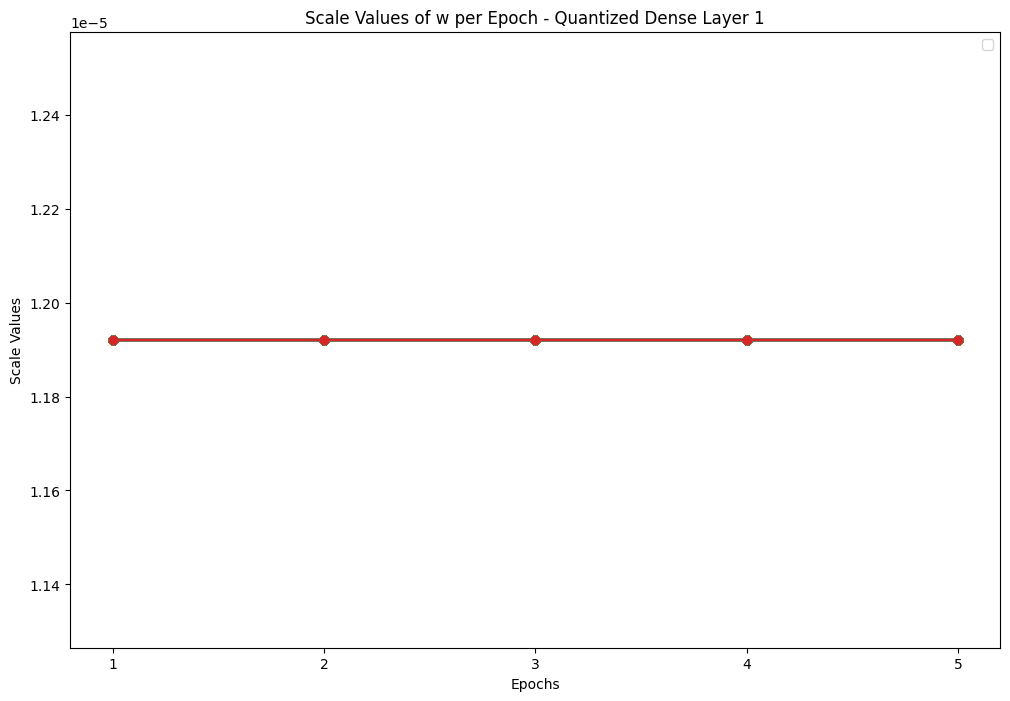

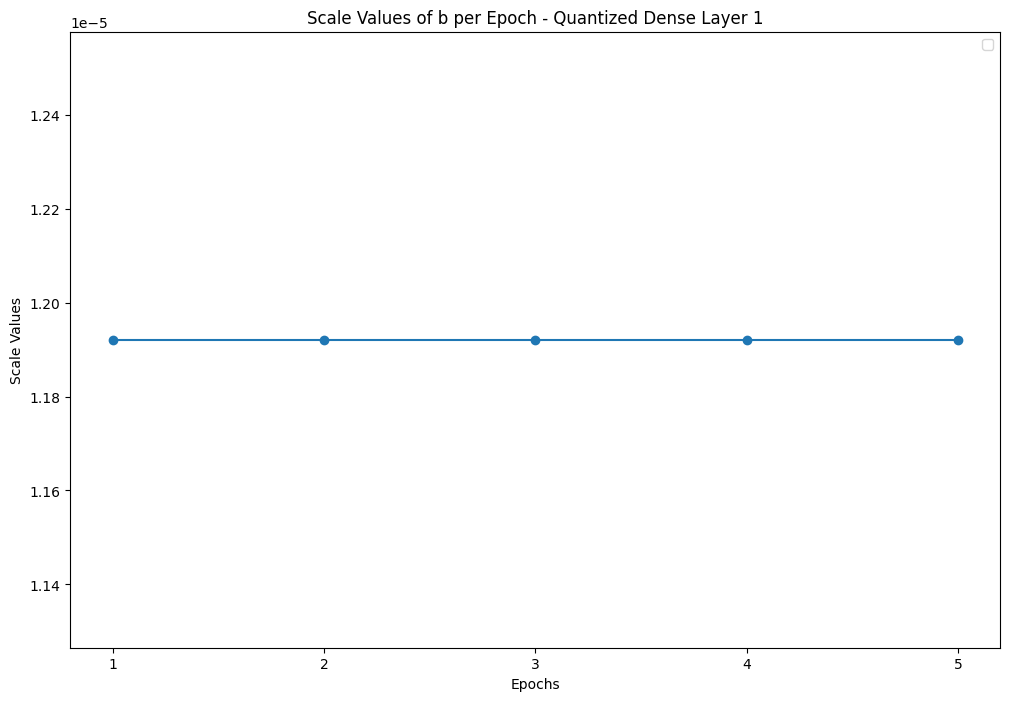

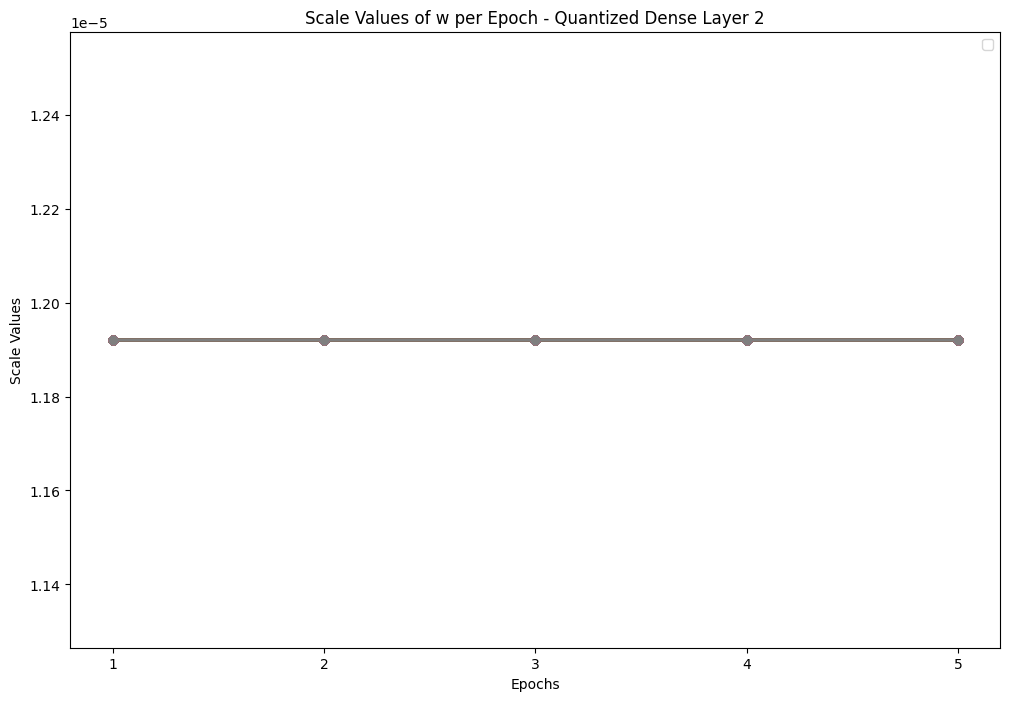

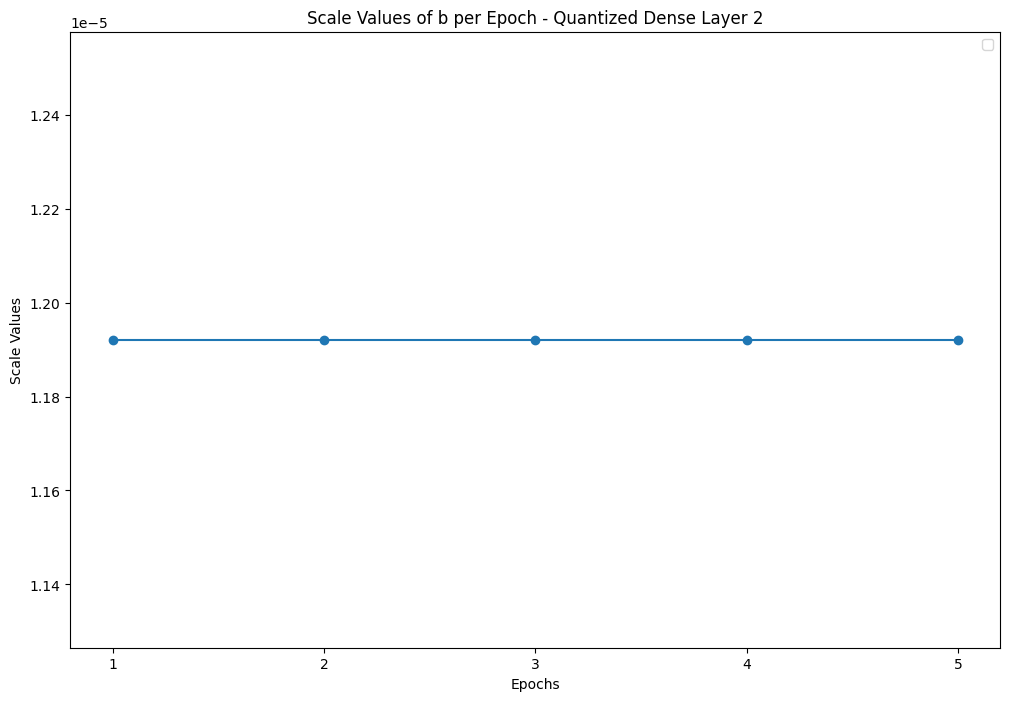

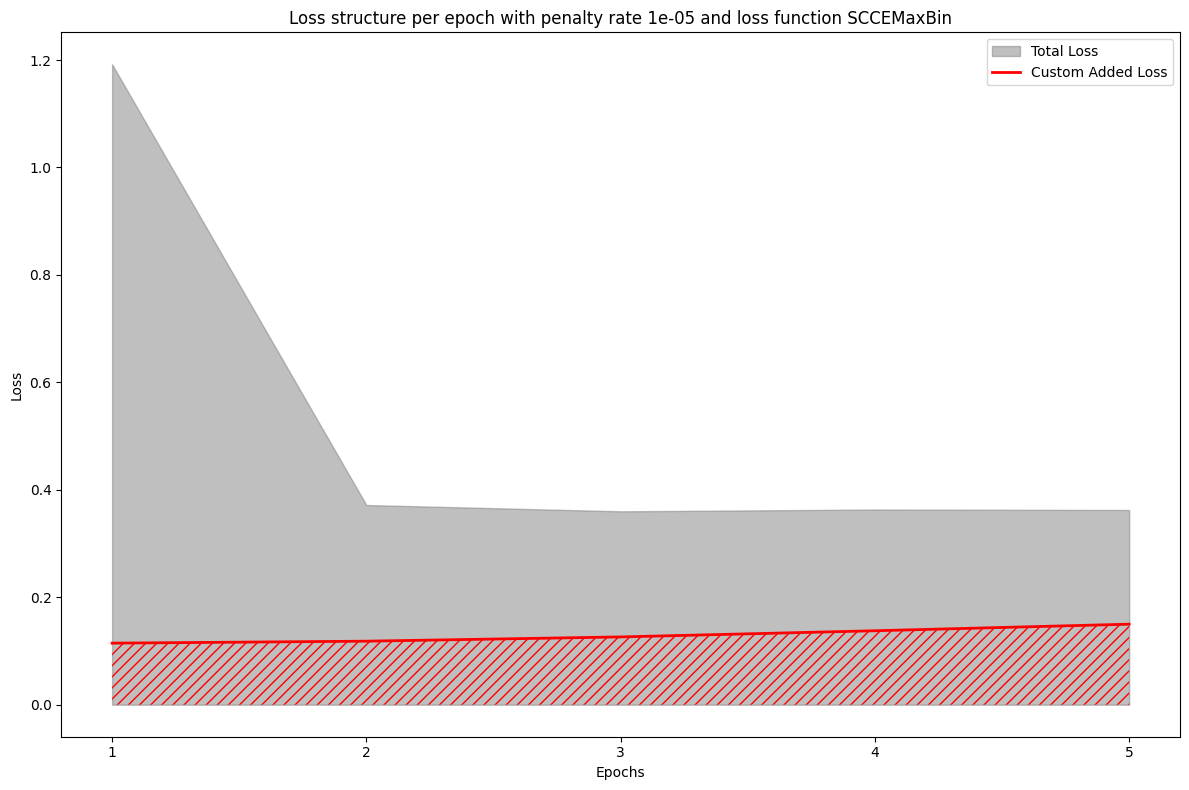

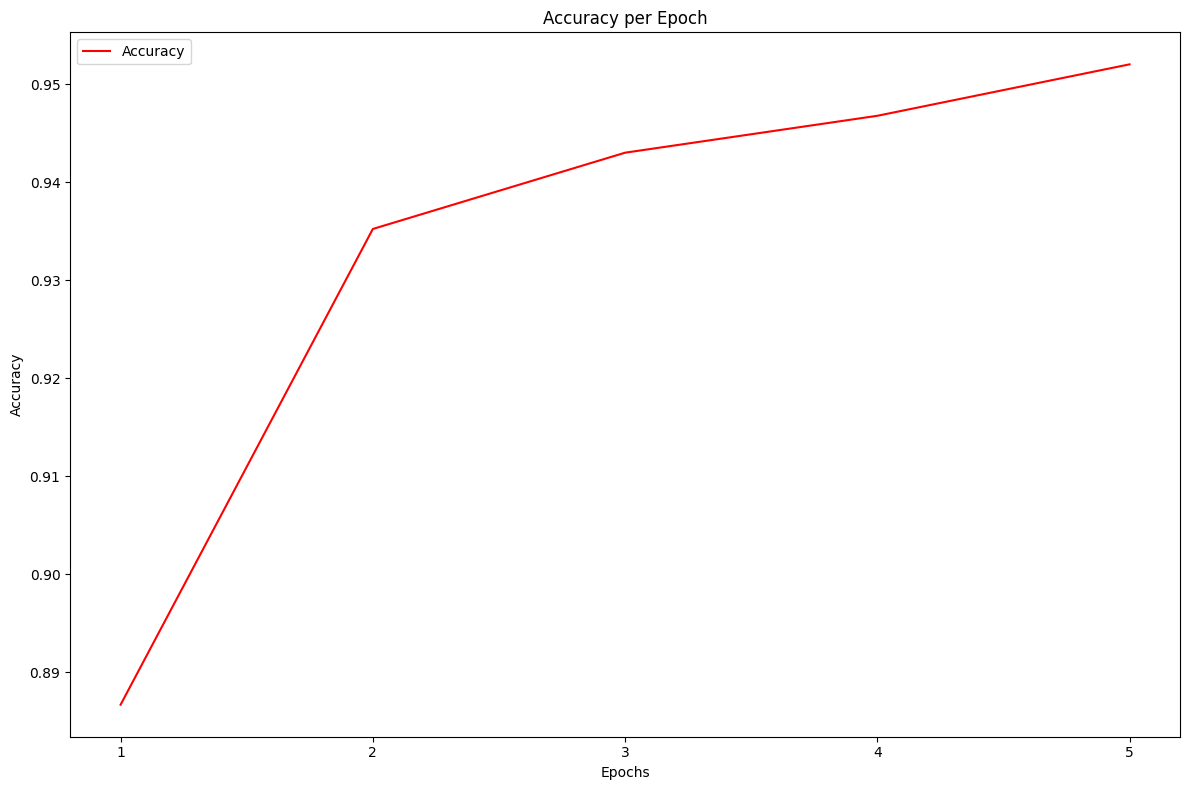

In [15]:
# Plot
scale_tracking_callback_first_dense_layer.plot_scale_values(layer_name="Quantized Dense Layer 1")
scale_tracking_callback_second_dense_layer.plot_scale_values(layer_name="Quantized Dense Layer 2")
penalty_callback.plot_loss()
accuracy_callback.plot_accuracy()

### **8. Before & After quantization**

In [16]:

# Count number of unique values for w and b before and after quantization for each custom layer
count_unique_values(quantized_model)


--------------------------------------------------------------------------------
NUMBER OF UNIQUE VALUES FOR W AND B OF EACH CUSTOM LAYER
LAYER WITH IF:  0 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES
LAYER WITH IF:  1 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

LAYER WITH ID: 2
Unique values in w:  100290
Unique values in quantized w:  23550
Unique values in b:  128
Unique values in quantized b:  127
LAYER WITH IF:  3 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

LAYER WITH ID: 4
Unique values in w:  1280
Unique values in quantized w:  1222
Unique values in b:  10
Unique values in quantized b:  10
LAYER WITH IF:  5 DOESN'T HAVE SCALE FACTOR VALUES OR MEANINGFUL ONES

--------------------------------------------------------------------------------
